In [1]:
%matplotlib inline

from PIL import Image
import skvideo.io
import numpy as np
import torch
from torch.autograd import Variable
from torchvision import transforms
from tqdm import tqdm_notebook

from transformer_net import TransformerNet
from utils import recover_image, tensor_normalizer

/home/ceshine/miniconda3/envs/ds36/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [2]:
MODEL = "models/model_mosaic.pth"
transformer = TransformerNet()
transformer.load_state_dict(torch.load(MODEL))

In [3]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    tensor_normalizer()
])

## Low Resolution GIF Animation

Convert gif file to video file: 
```
ffmpeg -f gif -i cat.gif cat.mp4
```

In [4]:
skvideo.io.ffprobe("videos/cat.mp4")

{'video': OrderedDict([('@index', '0'),
              ('@codec_name', 'h264'),
              ('@codec_long_name',
               'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10'),
              ('@profile', 'High 4:4:4 Predictive'),
              ('@codec_type', 'video'),
              ('@codec_time_base', '3/200'),
              ('@codec_tag_string', 'avc1'),
              ('@codec_tag', '0x31637661'),
              ('@width', '300'),
              ('@height', '300'),
              ('@coded_width', '304'),
              ('@coded_height', '304'),
              ('@has_b_frames', '2'),
              ('@sample_aspect_ratio', '0:1'),
              ('@display_aspect_ratio', '0:1'),
              ('@pix_fmt', 'yuv444p'),
              ('@level', '21'),
              ('@chroma_location', 'left'),
              ('@refs', '4'),
              ('@is_avc', '1'),
              ('@nal_length_size', '4'),
              ('@r_frame_rate', '100/3'),
              ('@avg_frame_rate', '100/3'),
              (

In [5]:
frames = []
frames_orig = []
videogen = skvideo.io.vreader("videos/cat.mp4")
for frame in videogen:
    frames_orig.append(Image.fromarray(frame))
    frames.append(recover_image(transformer(
        Variable(preprocess(frame).unsqueeze(0), volatile=True)).data.numpy())[0])

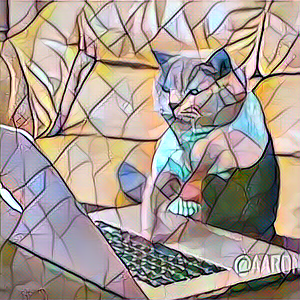

In [6]:
Image.fromarray(frames[3])

In [7]:
writer = skvideo.io.FFmpegWriter("cat.mp4")# tuple([len(frames)] + list(frames[0].shape)))
for frame in frames:
    writer.writeFrame(frame)
writer.close()

## Higher Resolution Videos

In [47]:
skvideo.io.ffprobe("videos/nz.mp4")

{'audio': OrderedDict([('@index', '1'),
              ('@codec_name', 'aac'),
              ('@codec_long_name', 'AAC (Advanced Audio Coding)'),
              ('@profile', 'LC'),
              ('@codec_type', 'audio'),
              ('@codec_time_base', '1/44100'),
              ('@codec_tag_string', 'mp4a'),
              ('@codec_tag', '0x6134706d'),
              ('@sample_fmt', 'fltp'),
              ('@sample_rate', '44100'),
              ('@channels', '2'),
              ('@channel_layout', 'stereo'),
              ('@bits_per_sample', '0'),
              ('@r_frame_rate', '0/0'),
              ('@avg_frame_rate', '0/0'),
              ('@time_base', '1/44100'),
              ('@start_pts', '0'),
              ('@start_time', '0.000000'),
              ('@duration_ts', '16418816'),
              ('@duration', '372.308753'),
              ('@bit_rate', '125596'),
              ('@nb_frames', '16034'),
              ('disposition',
               OrderedDict([('@default', '1'),
  

Switch to GPU:

In [71]:
transformer.cuda()
BATCH_SIZE = 2

In [60]:
batch = []
videogen = skvideo.io.FFmpegReader("videos/nz.mp4", {"-ss": "00:00:25", "-t": "00:00:15"})
writer = skvideo.io.FFmpegWriter("nz.mp4")
try:
    for frame in tqdm_notebook(videogen.nextFrame()):
        batch.append(preprocess(frame).unsqueeze(0))
        if len(batch) == BATCH_SIZE:
            for frame_out in recover_image(transformer(
                Variable(torch.cat(batch, 0), volatile=True).cuda()).data.cpu().numpy()):
                writer.writeFrame(frame_out)
            batch = []
except RuntimeError as e:
    pass
writer.close()

In [72]:
batch = []
videogen = skvideo.io.FFmpegReader("videos/keelung_360.mp4", {"-ss": "00:00:25", "-t": "00:00:30"})
writer = skvideo.io.FFmpegWriter("keelung.mp4")
try:
    for frame in tqdm_notebook(videogen.nextFrame()):
        batch.append(preprocess(frame).unsqueeze(0))
        if len(batch) == BATCH_SIZE:
            for frame_out in recover_image(transformer(
                Variable(torch.cat(batch, 0), volatile=True).cuda()).data.cpu().numpy()):
                writer.writeFrame(frame_out)
            batch = []
except RuntimeError as e:
    pass
writer.close()